<a href="https://colab.research.google.com/github/twishasaraiya/PyTorch-Scholarship-Lab-Challenge/blob/master/LAB_Image_Classifier_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='https://github.com/twishasaraiya/PyTorch-Scholarship-Lab-Challenge/blob/master/assets/Flowers.png?raw=1' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

### Download the libraries

In [0]:
!pip install torch==0.4.0
!pip install torchvision
!pip install Pillow==4.1.1

In [0]:
# Imports here
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,models,transforms,utils

import copy
import time
from collections import OrderedDict

from PIL import Image

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

### Load data from Google Drive

**Get Current directory path**

`import os`

`os.getcwd()`

**Change Path to given path**

`os.chdir('/content/gdrive/My Drive/[folder-name]/')`

This is required if you want to access the files and folders directly without specifying the entire path

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
!ls '/content/gdrive/My Drive/pytorch-challenge/'

 cat_to_name.json   flower_data.zip			   sample_flower.jpg
 checkpoint1.pth    flower_test.zip
 checkpoint.pth    'LAB: Image Classifier Project.ipynb'


In [0]:
!unzip '/content/gdrive/My Drive/pytorch-challenge/flower_data.zip'

In [0]:
!cp '/content/gdrive/My Drive/pytorch-challenge/cat_to_name.json' 'cat_to_name.json'

In [9]:
# Check if there is a folder called flower_data
!ls 

cat_to_name.json  gdrive  sample_data  test


### Access Data

In [0]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

data_root = {
    'train': train_dir,
    'valid': valid_dir
}

In [0]:
#  Check 
print(data_root['train'])

flower_data/train


In [0]:
#Set batch size
batch_size = 16

# TODO: Define your transforms for the training and validation sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
      ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])
}

# TODO: Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(data_root[x],data_transforms[x]) for x in ['train','valid']}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = { x: torch.utils.data.DataLoader(image_datasets[x],batch_size=batch_size,shuffle=True) for x in ['train','valid'] }

dataset_sizes = { x: len(image_datasets[x]) for x in ['train','valid'] }
class_names = image_datasets['train'].classes

### Visualize a batch of data

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [0]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [0]:
fig,ax = plt.subplots(figsize=(10,10))
def imshow(inp,title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  ax.imshow(inp)
  if title is not None:
      plt.title(title)
  plt.pause(0.001) 
  
  # Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = utils.make_grid(inputs)

imshow(out, title=[cat_to_name[str(x.item())] for x in classes])

#for x in classes:
 # print(x.item(), cat_to_name[str(x.item())] )

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

### Define Network Architecture

#### Load in VGG19
VGG19 is split into two portions:

_**vgg19.features**_, which are all the convolutional and pooling layers

_**vgg19.classifier**_, which are the three linear, classifier layers at the end

We only need the features portion, and we will define our own classifier.

In [0]:
model = models.vgg19(pretrained=True)

# freeze all VGG parameters since we're only optimizing the target image
for param in model.parameters():
    param.requires_grad_(False)

In [11]:
modelA = models.resnet152(pretrained=True)

for param in modelA.parameters():
  param.requires_grad=False

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.torch/models/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:02<00:00, 84561957.00it/s]


In [12]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if(device.type=="cuda"):
  print("Running on CUDA")

Running on CUDA


In [13]:
print(modelA)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

#### Build Your classifier

In [0]:
classifierA = nn.Linear(2048,102)
modelA.fc = classifierA

#### Define criterion and optimizer and scheduler

In [14]:
loss_fn = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(),lr=0.003)

scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=4,gamma=0.1)


NameError: ignored

In [0]:
loss_fn_A = nn.CrossEntropyLoss()
optimizerA = optim.Adam(modelA.fc.parameters(),lr=0.001)

schedulerA = optim.lr_scheduler.StepLR(optimizerA,step_size=5,gamma=0.1)


### Model Training

According to the docs (in PyTorch 0.4),

```with torch.set_grad_enabled(is_train)```

prevents tracking via autograd, which would make the inference mode more efficient.

Whereas `model.eval()` doesn’t turn off history tracking. 

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,device='cuda'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print('Saving model....')
                model.cpu()
                # Save model to start retraining from there
                save_checkpoint('/content/gdrive/My Drive/pytorch-challenge/checkpoint1.pth',model,optimizerA,best_acc,epoch)
                model.cuda()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
modelA.to(device)
#optimizer.zero_grad()

In [0]:
model_ft = train_model(modelA,loss_fn_A,optimizerA,schedulerA,15,device)

Epoch 0/14
----------
train Loss: 2.2867 Acc: 0.5124
valid Loss: 0.7071 Acc: 0.8215
Saving model....
Epochs 0 	 Best Accuracy 0.8215
!!!!!!!!!Checkpoint Saved!!!!!!!

Epoch 1/14
----------
train Loss: 0.9138 Acc: 0.7766
valid Loss: 0.4051 Acc: 0.8973
Saving model....
Epochs 1 	 Best Accuracy 0.8973
!!!!!!!!!Checkpoint Saved!!!!!!!

Epoch 2/14
----------
train Loss: 0.7310 Acc: 0.8127
valid Loss: 0.3470 Acc: 0.9059
Saving model....
Epochs 2 	 Best Accuracy 0.9059
!!!!!!!!!Checkpoint Saved!!!!!!!

Epoch 3/14
----------
train Loss: 0.6171 Acc: 0.8370
valid Loss: 0.3443 Acc: 0.9059

Epoch 4/14
----------
train Loss: 0.5672 Acc: 0.8483
valid Loss: 0.2865 Acc: 0.9254
Saving model....
Epochs 4 	 Best Accuracy 0.9254
!!!!!!!!!Checkpoint Saved!!!!!!!

Epoch 5/14
----------
train Loss: 0.4127 Acc: 0.8918
valid Loss: 0.1987 Acc: 0.9511
Saving model....
Epochs 5 	 Best Accuracy 0.9511
!!!!!!!!!Checkpoint Saved!!!!!!!

Epoch 6/14
----------
train Loss: 0.3693 Acc: 0.9025
valid Loss: 0.1904 Acc: 0.9

### Model Testing

In [0]:
!unzip '/content/gdrive/My Drive/pytorch-challenge/flower_test.zip'


In [6]:
!ls 

gdrive	sample_data  test


In [0]:
test_dir = 'test'
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])

#Load the datasets with ImageFolder
image_test_datasets = datasets.ImageFolder(test_dir,data_transform)

batch_size = 16

# TODO: Using the image datasets and the trainforms, define the dataloaders
test_dataloaders = torch.utils.data.DataLoader(image_test_datasets,batch_size=batch_size,shuffle=True)

test_dataset_size = len(image_test_datasets)

In [0]:
def calc_accuracy(model):
  model.eval()
  model.to(device)    
    
  running_corrects = 0
  
  with torch.no_grad():
    for (inputs, labels) in test_dataloaders:
      inputs, labels = inputs.cuda(), labels.cuda()
      # obtain the outputs from the model
      outputs = model.forward(inputs)
      # max provides the (maximum probability, max value)
      _, preds = torch.max(outputs,dim=1)
      running_corrects += torch.sum(preds == labels.data)
      
  acc = running_corrects.double() / test_dataset_size
  print('Overall accuracy of batch: ',acc)


In [35]:
calc_accuracy(modelA)

Overall accuracy of batch:  tensor(0.9365, dtype=torch.float64, device='cuda:0')


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
# TODO: Save the checkpoint 
def save_checkpoint(file_path,model,optimizer,best_acc,num_epochs):
  model.class_to_idx = image_datasets['train'].class_to_idx
  torch.save({
      'arch': 'resnet152',
      'num_epochs': num_epochs,
      'best_acc': best_acc,
      'model_state_dict': model.state_dict(),
      'optim_state_dict': optimizer.state_dict(),
      'class_to_idx': model.class_to_idx
  },file_path)
  print('Epochs {} \t Best Accuracy {:.4f}'.format(num_epochs,best_acc))
  print('!!!!!!!!!Checkpoint Saved!!!!!!!')



In [0]:
# TODO: call the function to save checkpoint
save_checkpoint('/content/gdrive/My Drive/pytorch-challenge/checkpoint.pth',modelA,optimizerA,10)

In [0]:
!ls '/content/gdrive/My Drive/pytorch-challenge/'


 cat_to_name.json   flower_data.zip  'LAB: Image Classifier Project.ipynb'
 checkpoint.pth     flower_test.zip   sample_flower.jpg


**Save on GPU, Load on CPU**

_**Save:**_

`torch.save(model.state_dict(), PATH)`

_**Load:**_

`device = torch.device('cpu')``

`model = TheModelClass(*args, **kwargs)`

`model.load_state_dict(torch.load(PATH, map_location=device))`

When loading a model on a CPU that was trained with a GPU, pass torch.device('cpu') to the map_location argument in the torch.load() function. In this case, the storages underlying the tensors are dynamically remapped to the CPU device using the map_location argument.

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [19]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(file_path,model,optimizer):
  print(file_path)
  checkpoint = torch.load(file_path)
  print('Epochs {} \n Best Accuracy {}'.format(checkpoint['num_epochs'], checkpoint['best_acc']))
        
  if checkpoint['arch'] == 'resnet152':
    model = models.resnet152(pretrained=True)
    for param in model.parameters():
      param.requires_grad= False
        
  else: 
    print('Architecture mistmatch')
    return None
  
  
  model.class_to_idx = checkpoint['class_to_idx']
    
  # Create the classifier
  classifier = nn.Linear(2048,102)
  # Put the classifier on the pretrained network
  model.fc = classifier
    
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optim_state_dict'])
  return model


modelA = load_checkpoint('/content/gdrive/My Drive/pytorch-challenge/checkpoint1.pth',modelA,optimizerA)
print(modelA)

/content/gdrive/My Drive/pytorch-challenge/checkpoint1.pth
Epochs 13 
 Best Accuracy 0.9572127139364303
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

[`Check this Link`](https://discuss.pytorch.org/t/how-to-classify-single-image-using-loaded-net/1411)

In [0]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    pil_img = Image.open(image_path)
    
    #resize and crop
    loader = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
    
    pil_img = loader(pil_img).float()
    
    # Convert to numpy array
    np_img = np.array(pil_img)/255
    
    # Normalize the pixel values
    mean =  np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_img = (np.transpose(np_img, (1, 2, 0)) - mean)/std
    
    # Transpose
    np_img = np.transpose(np_img,(2, 0, 1))
    
    return np_img

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imgshow(image, ax=None, title='Sample Flower'):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = np.transpose(image, (1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    image = image*255
    ax.imshow(image)
    
    if title is not None:
      plt.title(title)
    return ax


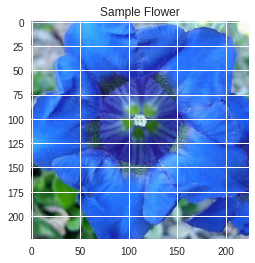

In [0]:
image_path = '/content/gdrive/My Drive/pytorch-challenge/sample_flower.jpg'
image_path_2 = 'flower_data/valid/28/image_05258.jpg'
_ = imgshow(process_image(image_path_2))
plt.imshow(_)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
def predict(image_path,model, num_k=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.eval()  # switch to evaluation mode
    model.cpu()
    # Process the image
    np_img = process_image(image_path)
    # Numpy -> Tensor
    img_tensor = torch.from_numpy(np_img).type(torch.FloatTensor)
    img_tensor = torch.unsqueeze(img_tensor,0)
    
    probs = torch.exp(model.forward(img_tensor))
    
   # Top probs
    top_probs, top_labs = probs.topk(num_k)
    top_probs = top_probs.detach().numpy().tolist()[0]
    top_labs = top_labs.detach().numpy().tolist()[0]

    # Convert indices to classes
    idx_to_class = {val: key for key, val in
                    model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [cat_to_name[idx_to_class[lab]] for lab in top_labs]
    return top_probs, top_labels, top_flowers
    # TODO: Implement the code to predict the class from an image file

In [0]:
probs, classes, flowers = predict(image_path,modelA)
print(probs)
print(classes)
print(flowers)
probs, classes, flowers = predict(image_path_2,modelA)
print(probs)
print(classes)
print(flowers)


[0.12928663194179535, 0.10851597785949707, 0.06396835297346115, 0.03509312495589256, 0.03484126925468445]
['56', '48', '63', '14', '80']
['bishop of llandaff', 'buttercup', 'black-eyed susan', 'spear thistle', 'anthurium']
[0.11038767546415329, 0.09318229556083679, 0.06020175293087959, 0.06002287566661835, 0.05346790328621864]
['48', '56', '63', '14', '17']
['buttercup', 'bishop of llandaff', 'black-eyed susan', 'spear thistle', 'purple coneflower']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='https://github.com/twishasaraiya/PyTorch-Scholarship-Lab-Challenge/blob/master/assets/inference_example.png?raw=1' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
# TODO: Display an image along with the top 5 classes
def plot_solution(img_path):
  fig, (ax1,ax2) =plt.subplots(1,2)
  fig.figsize = (15,15)
  
  _ = imgshow(process_image(img_path),ax2)
  
  probs,classes,flowers = predict(img_path,modelA)
 
  ax1.barh(flowers,probs)
  
  plt.show()

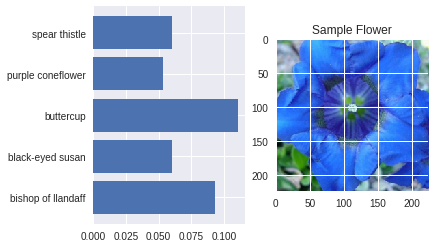

In [0]:
plot_solution(image_path_2)